In [1]:
import numpy as np 
import pandas as pd
import os
import glob
import re
import sys

import plotnine
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import animation, rc
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
import plotly.express as px
import folium
import branca
import json

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.io as pio
pio.renderers.default = "svg"

In [2]:
files = glob.glob('dataset/*.csv')
data = []
for i in files :
    i = re.sub("dataset/", "", i)
    data.append(re.sub(".csv","",i))
for i in range(len(files)) :
    globals()[data[i]] = pd.read_csv(files[i])
data

['TimeAge',
 'SearchTrend',
 'TimeProvince',
 'Weather',
 'PatientRoute',
 'PatientInfo',
 'Region',
 'TimeGender',
 'Case',
 'Time']

In [4]:
PatientInfo.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [5]:
inf_count = pd.DataFrame(PatientInfo.infection_case.value_counts())

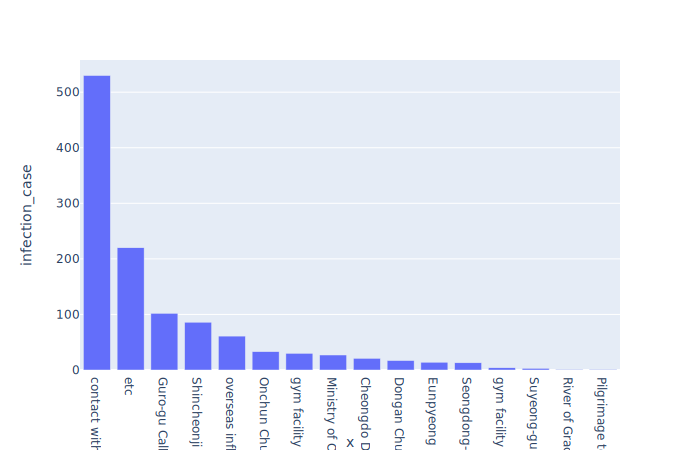

In [7]:
fig_0 = px.bar(inf_count,x=inf_count.index, y='infection_case')
fig_0.show()

In [8]:
inf_case = PatientInfo.infection_case.unique()
for i in range(len(inf_case)) :
    globals()['case'+ str(i)] = PatientInfo[PatientInfo.infection_case == inf_case[i]]
    globals()['case'+str(i)] = pd.DataFrame(globals()['case'+ str(i)].groupby('confirmed_date').count().cumsum().patient_id).reset_index()
    globals()['case'+str(i)].columns = ['confirmed_date','case'+str(i)]   

In [9]:
merged = case0
for i in [x for x in range(len(inf_case)) if x != 0] :
    merged = pd.merge(merged , globals()['case'+str(i)],how= 'outer',on='confirmed_date')
merged = merged.sort_values(by = 'confirmed_date').reset_index()
merged = merged.drop('index',axis=1)
merged.columns = np.insert(inf_case,0,'confirmed_date')
merged = merged.fillna(method='pad')
merged = merged.fillna(0)
merged = merged.set_index('confirmed_date')

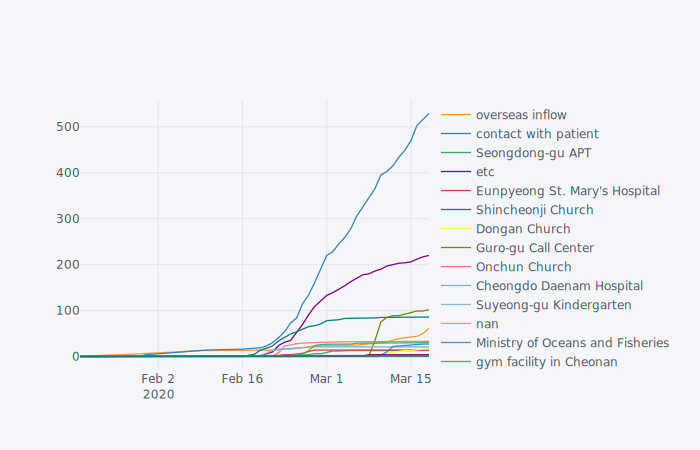

In [10]:
fig = merged.iplot(asFigure=True, kind='scatter')
fig.show()

초반에는 overseas inflow 가 먼저 시작; 다른 감염원들의 기울기는 평평해지고 있는데 contact with patient 의 기울기는 뭔가 안 평평해지고 있음. 근데 해외 유입은 왜 기울기가 다시 가팔라지기 시작한거지?....

In [3]:
Case.head()

,case_id,province,city,group,infection_case,confirmed,latitude,longitude
0,1000001,Seoul,Guro-gu,True,Guro-gu Call Center,79,37.508163,126.884387
1,1000002,Seoul,Dongdaemun-gu,True,Dongan Church,24,37.592888,127.056766
2,1000003,Seoul,Eunpyeong-gu,True,Eunpyeong St. Mary's Hospital,14,37.63369,126.9165
3,1000004,Seoul,Seongdong-gu,True,Seongdong-gu APT,13,37.55713,127.0403
4,1000005,Seoul,Jongno-gu,True,Jongno Community Center,10,37.57681,127.006
